<a href="https://colab.research.google.com/github/SamanZargarzadeh/Stock-Market-Data-Analysis/blob/main/Stock_Recom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
!pip install ta
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout




  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=9e2d21fa4203d644efd9fcef57a41660f729c0e29609ca02c6523a5a9cde4a3a
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [6]:
# Function to get historical stock data from Yahoo Finance
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [22]:
# Function to analyze stock data and create technical indicators
def analyze_stock(stock_data):
    # Calculate technical indicators using the 'ta' library
    # Use a window size for ATR that is smaller or equal to the number of data points available
    window_size = min(10, len(stock_data))  # Use a window size of 10 or less

    stock_data = ta.add_all_ta_features(
        stock_data, open='Open', high='High', low='Low', close='Close', volume='Volume', fillna=True
    )

    # Update the ATR calculation to use the correct window size
    stock_data[f'volatility_atr_{window_size}'] = AverageTrueRange(
        close=stock_data['Close'], high=stock_data['High'], low=stock_data['Low'], window=window_size, fillna=True
    ).average_true_range()

    return stock_data


In [8]:
# Function to train a Random Forest model for classification
def train_random_forest_model(stock_data):
    X = stock_data.drop(columns=['target', 'Date', 'Adj Close'])
    y = stock_data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Random Forest Model Accuracy:", accuracy)

    return rf_model

In [9]:
# Function to train an LSTM model for stock price prediction
def train_lstm_model(stock_data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(stock_data[['Close']])

    X, y = [], []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, batch_size=1, epochs=5)

    return model

In [10]:
# Function to train an SVM model for classification
def train_svm_model(stock_data):
    X = stock_data.drop(columns=['target', 'Date', 'Adj Close'])
    y = stock_data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("SVM Model Accuracy:", accuracy)

    return svm_model

In [12]:
# Function to build a Deep Q-Network (DQN) model
def build_dqn_model(input_shape, output_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to train a Deep Q-Network (DQN) model using Deep Q-Learning
def train_dqn_model(stock_data, dqn_model, num_episodes=100, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(stock_data[['Close']])


    memory = []  # Memory buffer for experience replay

    for episode in range(num_episodes):
        state = scaled_data[0]  # Initial state
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() <= epsilon:
                action = np.random.choice([0, 1, 2])  # Random action (buy, sell, hold)
            else:
                q_values = dqn_model.predict(np.expand_dims(state, axis=0))
                action = np.argmax(q_values[0])

            next_state = scaled_data[action + 1]

            # Calculate reward based on the profit/loss from the action
            reward = next_state[0] - state[0]

            memory.append((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            if len(memory) > 32:
                # Perform experience replay to train the DQN
                minibatch = np.random.choice(len(memory), size=32, replace=False)
                for idx in minibatch:
                    state_mem, action_mem, reward_mem, next_state_mem, done_mem = memory[idx]
                    target = reward_mem

                    if not done_mem:
                        target = reward_mem + gamma * np.max(dqn_model.predict(np.expand_dims(next_state_mem, axis=0)))

                    target_values = dqn_model.predict(np.expand_dims(state_mem, axis=0))
                    target_values[0][action_mem] = target

                    dqn_model.fit(np.expand_dims(state_mem, axis=0), target_values, epochs=1, verbose=0)

        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    return dqn_model

In [13]:
def apply_risk_management(stock_data, model):
    # Calculate stop-loss and take-profit levels based on ATR
    stop_loss_pct = 0.02  # 2% stop-loss
    take_profit_pct = 0.05  # 5% take-profit

    stock_data['Stop_Loss'] = stock_data['Close'] - stock_data['ATR'] * stop_loss_pct
    stock_data['Take_Profit'] = stock_data['Close'] + stock_data['ATR'] * take_profit_pct

    # Make predictions using the trained model
    X = stock_data[['SMA_50', 'SMA_200', 'RSI', 'MACD', 'Ichimoku_Span_A', 'Ichimoku_Span_B', 'ATR', 'CCI']]
    stock_data['Predicted_Signal'] = model.predict(X)

    # Apply risk management based on predicted signals
    stock_data['Signal'] = 0
    stock_data.loc[stock_data['Predicted_Signal'] == 1, 'Signal'] = 1
    stock_data.loc[stock_data['Predicted_Signal'] == 0, 'Signal'] = -1

    # Apply stop-loss and take-profit levels
    stock_data['Trade_Type'] = stock_data['Signal'].diff()
    stock_data.loc[stock_data['Trade_Type'] == -2, 'Signal'] = 0
    stock_data['Signal'] = stock_data['Signal'].ffill()

    return stock_data


In [14]:
# Function to predict action using the DQN model
def dqn_predict_action(state, dqn_model):
    q_values = dqn_model.predict(np.expand_dims(state, axis=0))
    return np.argmax(q_values[0])

In [15]:
# Function to get the latest data for the specified ticker up to the end_date
def get_latest_data(ticker_symbol, end_date):
    start_date = pd.to_datetime(end_date) - pd.Timedelta(days=7)  # Data for the past week
    stock_data = get_stock_data(ticker_symbol, start_date=start_date, end_date=end_date)
    return stock_data

In [16]:
# Function to get the weekly recommendation for the specified ticker
def get_recommendation(ticker_symbol, end_date):
    latest_data = get_latest_data(ticker_symbol, end_date)

    # Perform analysis and train models on historical data up to the current week
    analyzed_stock_data = analyze_stock(latest_data)
    random_forest_model = train_random_forest_model(analyzed_stock_data)
    lstm_model = train_lstm_model(analyzed_stock_data)
    svm_model = train_svm_model(analyzed_stock_data)
    input_shape = (1,)  # Number of features in the state representation
    output_shape = 3  # Number of actions (buy, sell, hold)
    dqn_model = build_dqn_model(input_shape, output_shape)
    dqn_model = train_dqn_model(analyzed_stock_data, dqn_model)

    # Apply risk management based on LSTM predictions
    analyzed_stock_data = apply_risk_management(analyzed_stock_data, lstm_model)

    # Predict action using DQN model for the next week
    last_state = np.array([analyzed_stock_data['Close'].iloc[-1]])
    action = dqn_predict_action(last_state, dqn_model)

    # Convert action to human-readable recommendation
    if action == 0:  # Buy
        recommendation = "Buy"
    elif action == 1:  # Sell
        recommendation = "Sell"
    else:  # Hold
        recommendation = "Hold"

    return recommendation

In [23]:

ticker_symbol = 'AAPL'
end_date = '2023-07-21'

recommendation = get_recommendation(ticker_symbol, end_date)
print(f"Recommendation for {ticker_symbol} for the next week: {recommendation}")


[*********************100%***********************]  1 of 1 completed


IndexError: ignored

[*********************100%***********************]  1 of 1 completed


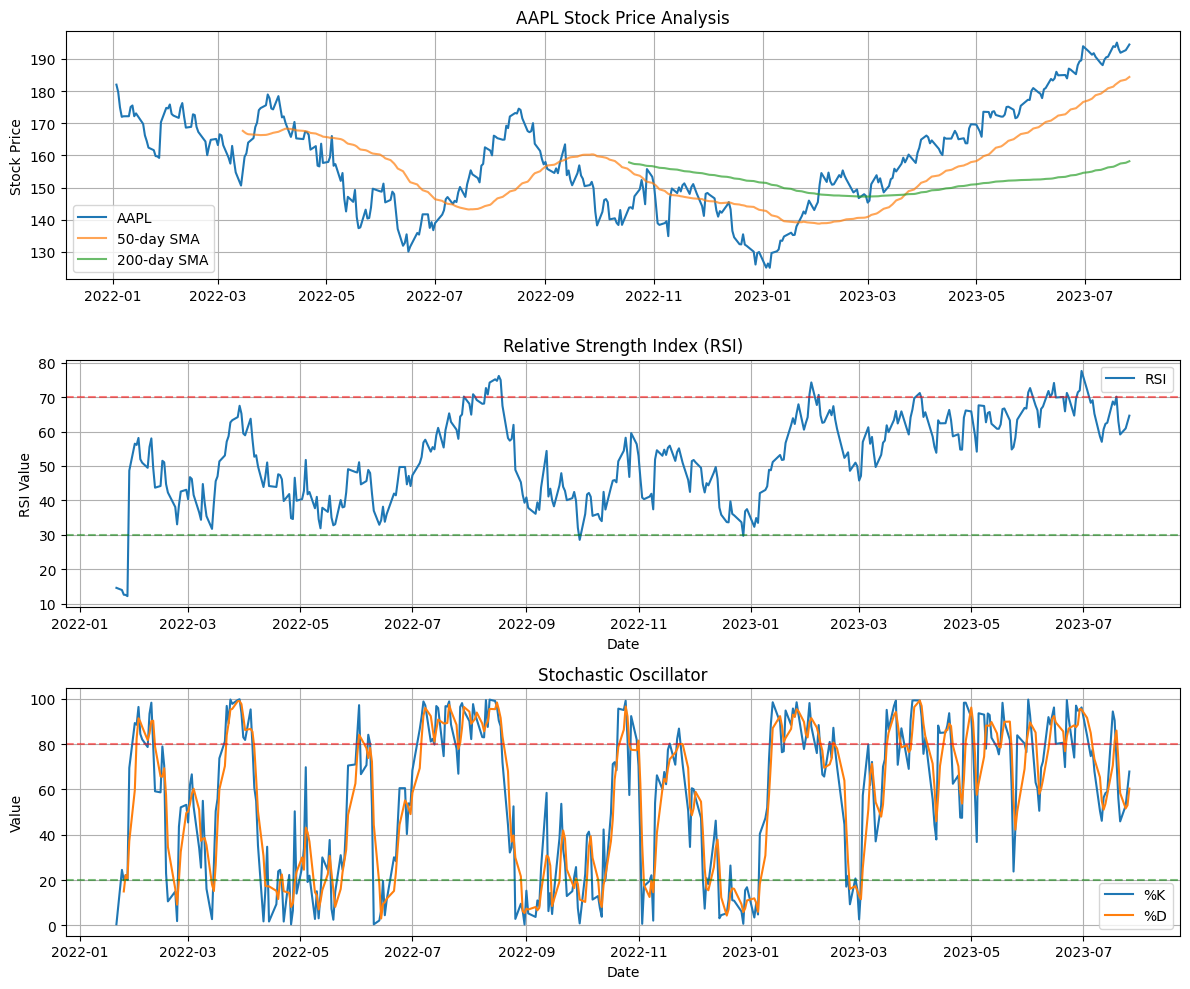

[*********************100%***********************]  1 of 1 completed


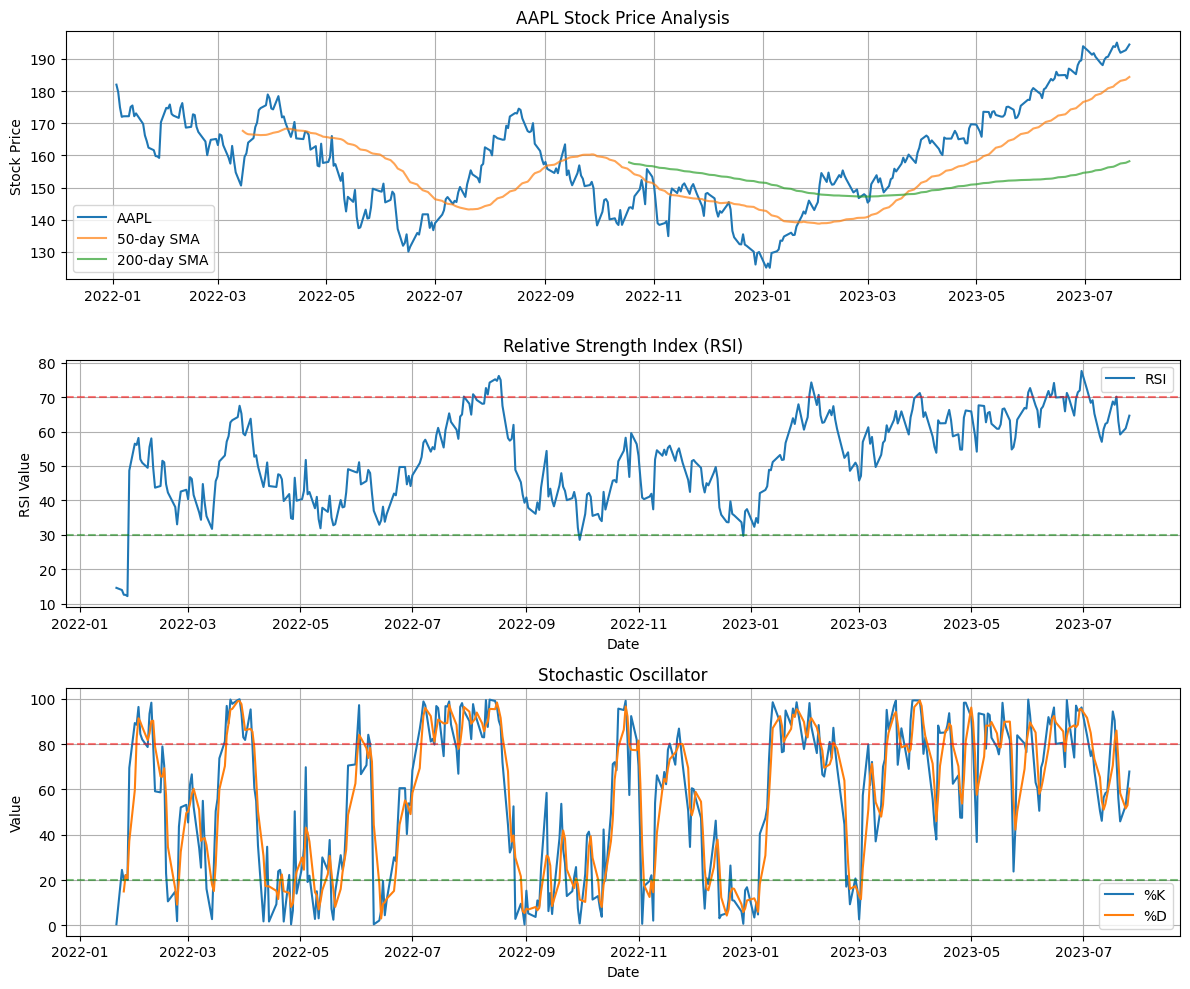

Recommendation for AAPL for the following week: Buy


In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def analyze_stock(stock_data):
    # Calculate the moving averages for 50 days and 200 days
    stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()

    # Calculate other technical indicators using the 'ta' library
    stock_data['RSI'] = ta.momentum.RSIIndicator(stock_data['Close']).rsi()
    stock_data['MACD'] = ta.trend.MACD(stock_data['Close']).macd()

    # Calculate Stochastic Oscillator
    stock_data['%K'] = ta.momentum.StochasticOscillator(stock_data['High'], stock_data['Low'], stock_data['Close']).stoch()
    stock_data['%D'] = stock_data['%K'].rolling(window=3).mean()

    # Calculate Ichimoku Cloud
    cloud = ta.trend.IchimokuIndicator(stock_data['High'], stock_data['Low'])
    stock_data['Ichimoku_Span_A'] = cloud.ichimoku_a()
    stock_data['Ichimoku_Span_B'] = cloud.ichimoku_b()

    # Generate buy/sell signals based on technical indicators
    stock_data['Signal'] = 0
    stock_data.loc[
        (stock_data['SMA_50'] > stock_data['SMA_200']) &
        (stock_data['RSI'] > 50) &
        (stock_data['%K'] > stock_data['%D']) &
        (stock_data['Close'] > stock_data['Ichimoku_Span_A']) &
        (stock_data['Close'] > stock_data['Ichimoku_Span_B']),
        'Signal'] = 1
    stock_data.loc[
        (stock_data['SMA_50'] < stock_data['SMA_200']) &
        (stock_data['RSI'] < 50) &
        (stock_data['%K'] < stock_data['%D']) &
        (stock_data['Close'] < stock_data['Ichimoku_Span_A']) &
        (stock_data['Close'] < stock_data['Ichimoku_Span_B']),
        'Signal'] = -1

    return stock_data

def plot_stock_data(stock_data, ticker):
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 1, 1)
    plt.plot(stock_data.index, stock_data['Close'], label=ticker)
    plt.plot(stock_data.index, stock_data['SMA_50'], label='50-day SMA', alpha=0.7)
    plt.plot(stock_data.index, stock_data['SMA_200'], label='200-day SMA', alpha=0.7)
    plt.title(f'{ticker} Stock Price Analysis')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(stock_data.index, stock_data['RSI'], label='RSI')
    plt.axhline(30, color='green', linestyle='--', alpha=0.5)
    plt.axhline(70, color='red', linestyle='--', alpha=0.5)
    plt.title('Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI Value')
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(stock_data.index, stock_data['%K'], label='%K')
    plt.plot(stock_data.index, stock_data['%D'], label='%D')
    plt.axhline(20, color='green', linestyle='--', alpha=0.5)
    plt.axhline(80, color='red', linestyle='--', alpha=0.5)
    plt.title('Stochastic Oscillator')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
name="main"
if name == "main":
    # Replace these values with your desired stock symbol, start date, and end date
    ticker_symbol = 'AAPL'
    start_date = '2022-01-01'
    end_date = '2023-08-20'

    stock_data = get_stock_data(ticker_symbol, start_date, end_date)
    analyzed_stock_data = analyze_stock(stock_data)
    plot_stock_data(analyzed_stock_data, ticker_symbol)

def get_weekly_recommendation(analyzed_stock_data):
    # Get the last row of analyzed_stock_data, which contains the latest data
    latest_data = analyzed_stock_data.iloc[-1]

    if latest_data['Signal'] == 1:
        recommendation = 'Buy'
    elif latest_data['Signal'] == -1:
        recommendation = 'Sell'
    else:
        recommendation = 'Hold'

    return recommendation

if name == "main":
    # Replace these values with your desired stock symbol, start date, and end date
    ticker_symbol = 'AAPL'
    #start_date = '2022-01-01'
    #end_date = '2023-01-01'

    stock_data = get_stock_data(ticker_symbol, start_date, end_date)
    analyzed_stock_data = analyze_stock(stock_data)
    plot_stock_data(analyzed_stock_data, ticker_symbol)

    # Get the recommendation for the following week
    weekly_recommendation = get_weekly_recommendation(analyzed_stock_data)
    print(f"Recommendation for {ticker_symbol} for the following week: {weekly_recommendation}")